In [ ]:
!pip install wand

!apt install imagemagick

!pip install myqlm

!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 3.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblqr-1-0
  libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra libmagickwand-6.q16-6
  libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch inkscape libjxr-tools libwmf0.2-7-gtk
  poppler-uti

In [ ]:
exit()

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    
    val = sum((2*b[i]-1) * (2*b[j]-1) for i,j in edges)
      
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print("BEST VALUE:", best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

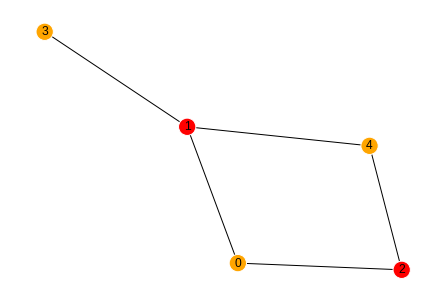

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm


G = nx.Graph(edges)
color_map = ['red' if best_b[node]==0 else 'orange' for node in range(len(best_b))]

# Set the style of the plot
plt.style.use('seaborn-darkgrid')
nx.draw(G, node_color=color_map, with_labels=True, edgecolors='white')

plt.show()


In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    #First layer of RX gates
    for k in range(n_qubits):
      layer.apply(RX(theta),k)
  
    #Second layer with cost function
    for (i,j) in edges:
      layer.apply(U_ZZ(beta),i,j)
    
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for k in range(n_qubits): #initialization with Hadamard gates
      prog.apply(H,qubits[k])
    for k in range(n_layers): #QAOA gates
      theta = parameters[2*k]
      beta = parameters[2*k+1]
      prog.apply(one_qaoa_layer(n_qubits, edges, theta, beta),qubits)

        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        val = 0
        b = [int(i)*2-1 for i in sample.state.bitstring] #transforms the string sample.state.bitstring to +1 or -1
        
        for edge in edges:
          i,j = edge
          val += b[i]*b[j]
        obs += val*sample.probability #compute the average result of the observable

    # END TODO
    return obs
    
        

In [ ]:
import numpy as np
np.random.random(3)

array([0.93474424, 0.79432016, 0.91255338])

In [ ]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

NUMBER OF LAYERS: 3
NUMBER OF LAYERS: 4
NUMBER OF LAYERS: 5


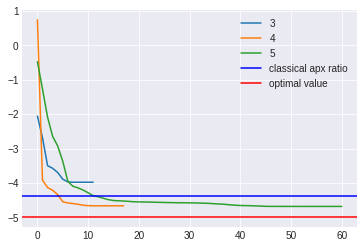

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(3,6,1):
    num_params = 2*nlayers
    print('NUMBER OF LAYERS:', nlayers)

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

Using adiabatic quantum computing method, we are going to initiate the parameters to generate the following evolution :

$$ exp\left(i\int_0^T H(s)ds\right) = \prod_{k=0}^{p-1}exp\left(-i(1-\frac{k}{p})\Delta t \times H_B\right) \times exp\left(-i \frac{k}{p} \Delta t \times H_C\right) $$ 

where $ \Delta t = T/p$.

This yields $\theta_k = (1-\frac{k}{p})*\Delta t$ and $\beta_k = \frac{k}{p} * \Delta t$.

3
4
5


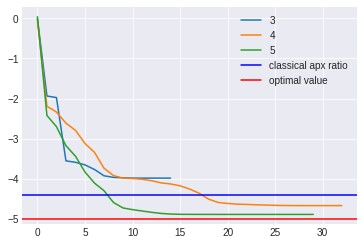

In [ ]:
T = 1.

for nlayers in range(3,6,1):
    print('NUMBER OF LAYERS:', nlayers)

    num_params = 2*nlayers
    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    # TODO implement parameter init
    delta_t = T/nlayers #Initialization of delta t
    parameters_init = [(1-k/nlayers)*delta_t for k in range(nlayers)] + [delta_t*k/nlayers for k in range(nlayers)]

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
    
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

#This initialization of parameters results in much faster convergence.
